Цель задания. В этом модуле мы будем заниматься практическим использованием методов понижения размерности. В этот раз в качестве зависимой переменной мы будем использовать переменную type — к какому типу относится наше вино.

План работы:
* EDA.
* Поиск корреляций.
* Сохранение доли объясненной дисперсии.
* Сравнение результатов работы разных алгоритмов понижения размерности.
* Сравнение результатов работы алгоритмов анализа данных до и после понижения размерности.
* Поиск аномалий в работе алгоритмов.

Обзор данных
Содержание. Этот набор данных содержит информацию о трех разных типах вина и ряд их характеристик.

Всего в датасете 13 характеристик: Alcohol, Malic, Ash, Alcalinity, Magnesium, Phenols, Flavanoids, Nonflavanoids, Proanthocyanins, Color, Hue, Dilution, Proline.

Мы будем работать с этим датасетом, используя алгоритмы понижения размерности и машинного обучения.

# Импорт библиотек


In [ ]:
%%capture
!pip install catboost
!pip install opentsne
!pip install umap-learn
# Data manipulation
import pandas as pd
pd.set_option("display.max_columns", None)
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import plotly.express as px

# Data preprocessing
from sklearn.model_selection import train_test_split as tts

# Dimensionality Reduction
from openTSNE.sklearn import TSNE
import umap
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score

# tqdm
from tqdm.auto import tqdm

# warnings
import warnings
warnings.filterwarnings('ignore')

# Импортируем датасет и посмотрим на его внутреннюю структуру:

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/ElijahSum/mipt_visualization/master/week_05_visualization/wine.csv')
data.head()

,Type,Alcohol,Malic,Ash,Alcalinity,Magnesium,Phenols,Flavanoids,Nonflavanoids,Proanthocyanins,Color,Hue,Dilution,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [ ]:
data.shape

(178, 14)

Очень маленький датасет, но ничего страшного зато алгоритмы будут работать весело и быстро

In [ ]:
# Сделаем копию
df = data.copy()

In [ ]:
# Сразу разобьем наши данные на X и y
X = df.drop(columns=['Type'], axis = 1)
y = df['Type']

In [ ]:
X.head()

,Alcohol,Malic,Ash,Alcalinity,Magnesium,Phenols,Flavanoids,Nonflavanoids,Proanthocyanins,Color,Hue,Dilution,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Type             178 non-null    int64  
 1   Alcohol          178 non-null    float64
 2   Malic            178 non-null    float64
 3   Ash              178 non-null    float64
 4   Alcalinity       178 non-null    float64
 5   Magnesium        178 non-null    int64  
 6   Phenols          178 non-null    float64
 7   Flavanoids       178 non-null    float64
 8   Nonflavanoids    178 non-null    float64
 9   Proanthocyanins  178 non-null    float64
 10  Color            178 non-null    float64
 11  Hue              178 non-null    float64
 12  Dilution         178 non-null    float64
 13  Proline          178 non-null    int64  
dtypes: float64(11), int64(3)
memory usage: 19.6 KB


In [ ]:
# Мы видим три типа вина, распределение примерно одинаковое, а данных и так мало будем работать с тем что есть
df['Type'].value_counts()

2    71
1    59
3    48
Name: Type, dtype: int64

In [ ]:
df.describe()

,Type,Alcohol,Malic,Ash,Alcalinity,Magnesium,Phenols,Flavanoids,Nonflavanoids,Proanthocyanins,Color,Hue,Dilution,Proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,1.938202,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.775035,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,1.000000,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,1.000000,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,2.000000,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,3.000000,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,3.000000,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


Вот тут конечно можно почитать разные показатели подметить смещение, но мы не для этого занимаемся визуализациями что бы ломать глаза от табличку:) мы сделаем анализ дальше по заданию изящно и красиво с использованием sns - на мой взгляд самой красивой библиотеки (plotly извините)

# Задание 1.

Разведочный анализ данных (2 балла)
Воспользуйтесь графиком sns.displot() и постройте 13 графиков распределения разных переменных на одном поле subplots. Параметр hue возьмите равным Type.

Напишите, какие выводы о различиях в типах вин можно сделать исходя из этих графиков.

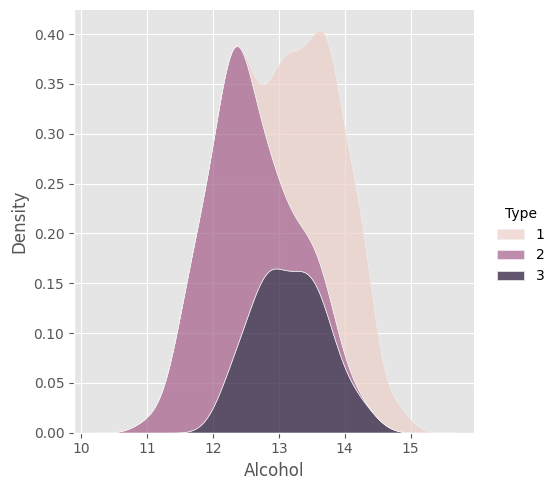

In [ ]:
# сначала построим 1 без гистограмм - красота же
sns.displot(df, x = 'Alcohol', hue='Type', kind="kde", multiple="stack")

Ну а теперь построим все 13, мы не будем добавлять кривую нормального распределения - и так слишном много всего на графике, но выводы делать будем

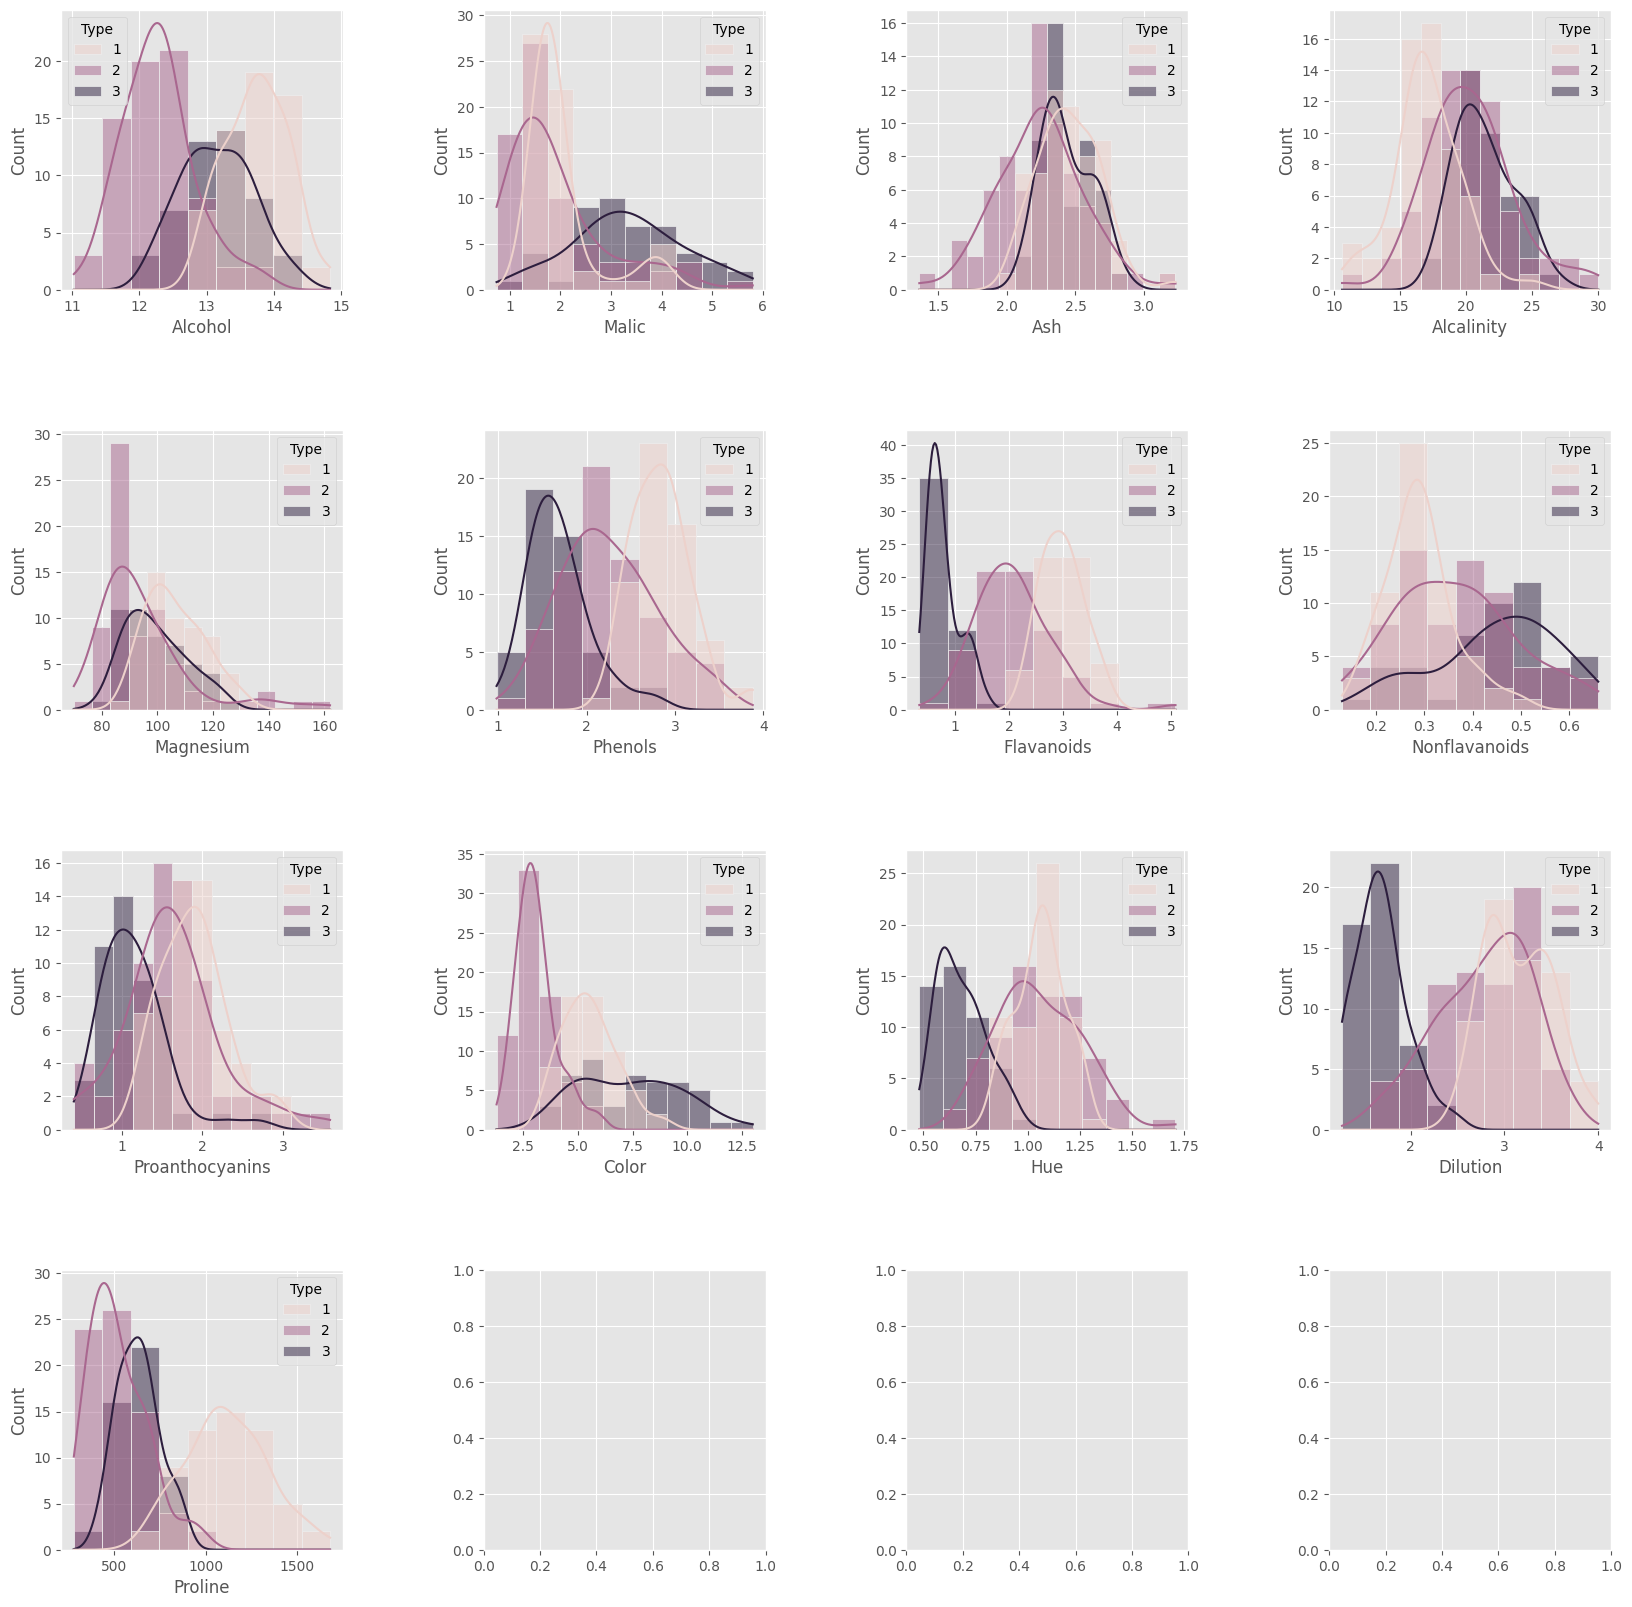

In [ ]:
# Построение графиков
fig, axs = plt.subplots(4, 4, figsize=(20, 20))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

columns = df.columns[1:]

for i, column in enumerate(columns):
    row = i // 4
    col = i % 4
    sns.histplot(data=df, x=column, hue='Type', kde=True, ax=axs[row, col])

plt.show()

 Итак, за точность перевода я не ручаюсь, но этои не важно - важно то что теперь мы видим распределения внутри каждого признака по типу вина, а значит мы можем уже предположительно понять по каким признакам можно хорошо классифицировать наши вина.


 * 1   Alcohol Алкоголь Распределения пересекаются, но тем не менее мы видим что тип 2 в среднем это более легкие вина, тип 1 посередине, а вот 3 тип это крепкие вина - думаю что алкоголь это важный параметр для классификации
 * 2   Malic Яблочный - яблочность вина странный параметр, возможно тут про использование яблок или это яблочные вина, не знаю, но тут первый и второй типы смешаны,  и только третий стоит немного справа по распределению. Это сложный параметр для классификации
 * 3   Ash Зола - все три распределения практически в одном колоколе, это нас только запутает - бесполезный параметр
 * 4   Alcalinity Щелочность - тут распределения близко, но и идут попорядку 1,2,3 но еще раз повторюсь перечечений много - сложный параметр
 * 5   Magnesium Магний - по магнию особняком слева стоит толкьо распредление типа вина №1
 * 6   Phenols Фенолы - мы имеет три относительно отдаленных распределения возможно этот параметр будет полезен
 * 7   Flavanoids Флаваноиды - а вот тут распределения хорошие мы видим три более менее отдельных холма - перечечения есть но они незначительные, это полежный параметр для классификации
 * 8   Nonflavanoids Нефлаваноиды - холмы пологие нет явного среднего, думаю будет бесполезен для классификации
 * 9   Proanthocyanins Проантоцианы - все очень близко, много пересений
 * 10  Color Цвет - я думал тут все будет скомкано, но нет вина 2 типа чаще всего одного цвета, а вот для других это не так значимо - холмы пологие много перечечений
 * 11  Hue Оттенок - оттенок позволяет выявить вина 3 типа, невольно вернулся к картинке 1 и понял что это вина средние по крепости
 * 12  Dilution Разбавление - соседняя картинка говорит нам что сердние по крепости вина это по сути разбавленные вина, отсюда у них и оттенок
 * 13  Proline Пролин - этот показатель особняком выделяет крепкие вина, возможно он будет полезен если мы выберем стратегию один против всех.


Итак наиболее интересными в плане классификации мне показались Флавониды и алкоголь, но глазам доверьть нельзя, особенно в части что касается вина. Вино все таки пробуют на вкус, ну а раз у нас нет такой возможности попробуем добиться результата медодами машинного оучения и понижения размерности. Но сначала используем более простой инструмент

# Задание 2.

Есть ли корреляции (1 балл)
Постройте sns.heatmap для всех числовых характеристик внутри датасета. Определите, какие три переменные больше всего коррелируют с типом вина. Добавьте стрелочки с текстом (функция annotate) с указанием на эти переменные.

Text(0.5, 1.0, 'Корреляционная матрица характеристик вина \n')

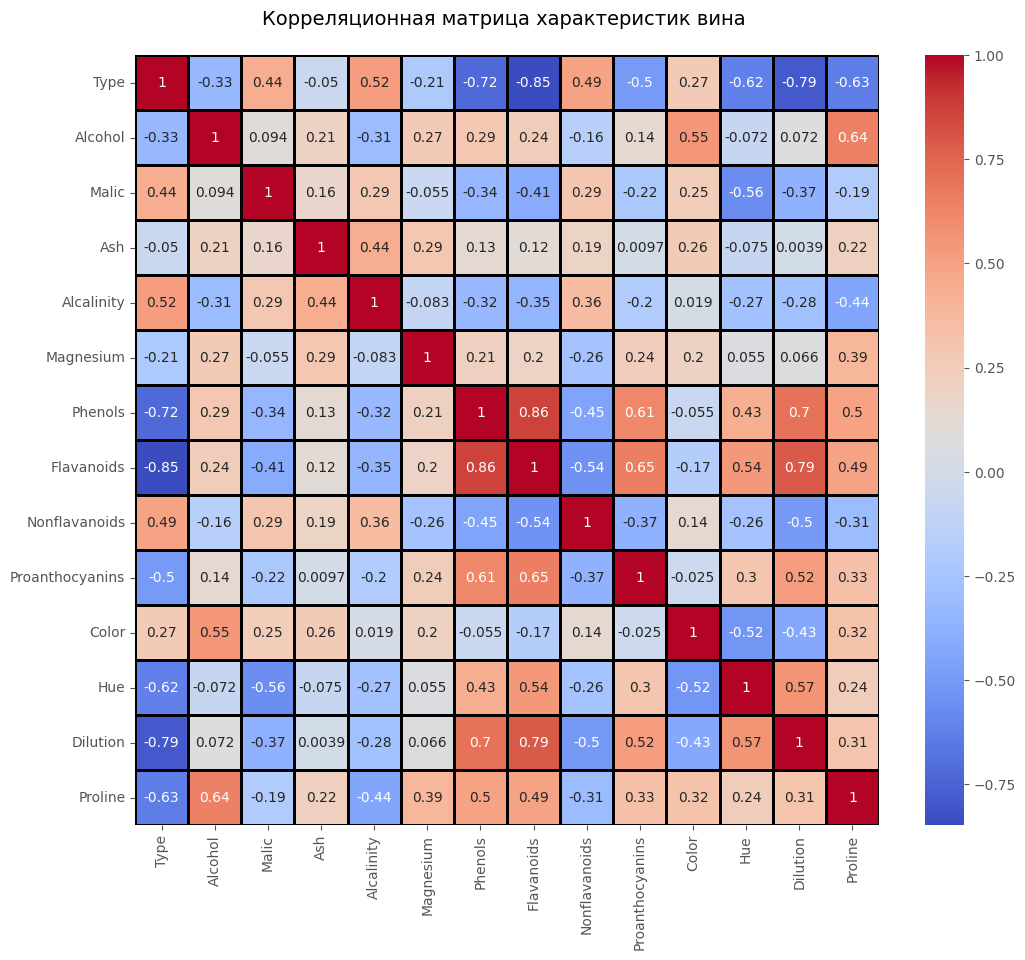

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))

corr = df.corr()
sns.heatmap(corr, cmap='coolwarm', annot=True, annot_kws={'size':10}, ax=ax, linewidths=2, linecolor='black')
ax.set_title("Корреляционная матрица характеристик вина \n", fontsize=14)

У нас получилась невероятно красивая тепловая карта корреляционных признаков и всего в несколько строк, но ее очень сложно смотреть (от красоты глаз замылемается), применим хитрость

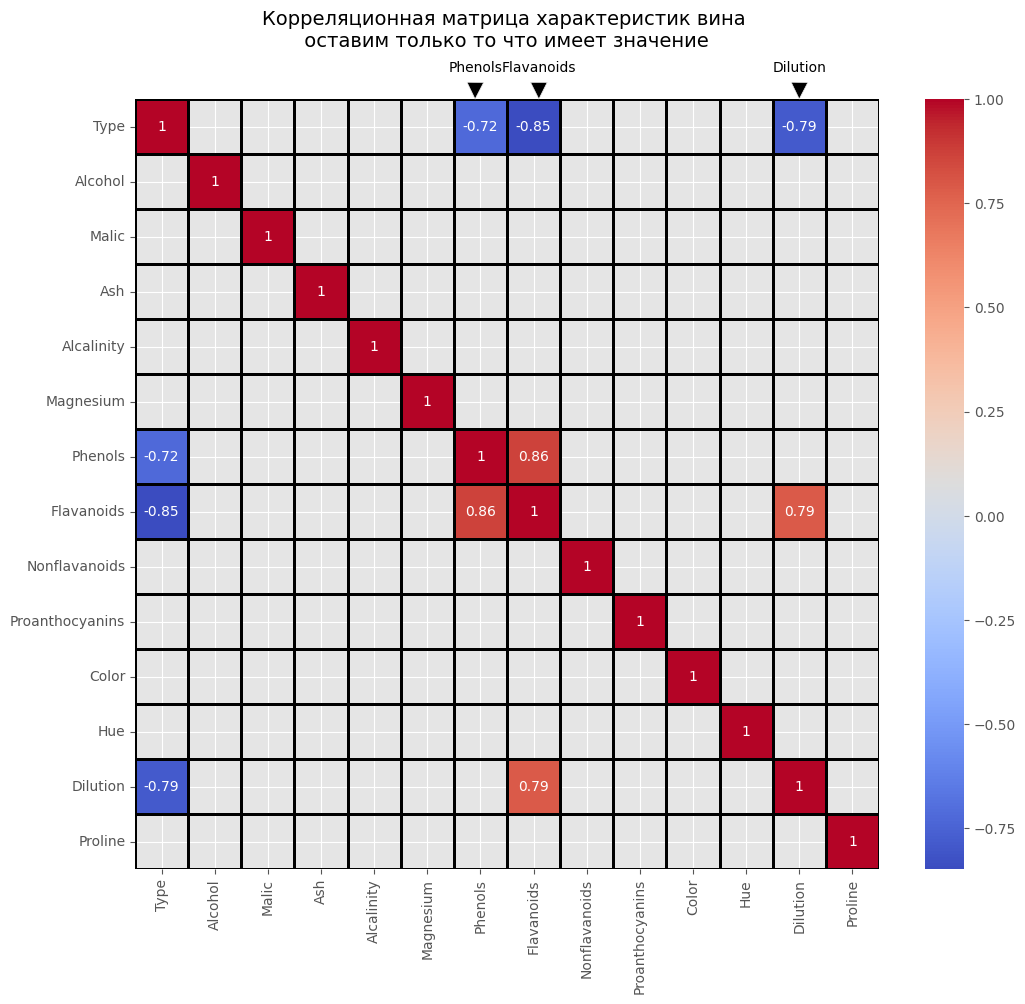

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))
# посмотрим только на то что имеет значение
matrix = (df.corr() <= 0.7) & (df.corr() >= -0.7)

sns.heatmap(df.corr(), cmap='coolwarm', annot=True, mask=matrix, ax = ax, linewidths=2, linecolor='black')
ax.set_title("Корреляционная матрица характеристик вина \n оставим только то что имеет значение \n\n", fontsize=14)
plt.annotate ('Phenols', xy = (6.4, 0), xytext=(5.9, -0.5), arrowprops= dict(facecolor = 'black', shrink=0.5))
plt.annotate ('Flavanoids', xy = (7.6, 0), xytext=(6.9, -0.5), arrowprops= dict(facecolor = 'black', shrink=0.5))
plt.annotate ('Dilution', xy = (12.5, 0), xytext=(12, -0.5), arrowprops= dict(facecolor = 'black', shrink=0.5))

plt.show()

Мы видим некоторые внутренние типы зависимостей, но между флавонидами и фенолами, но главное не это. Мы точно видим 3 характеристики которые максимально коррелируют с типом вина:
* Фенолы (-0.72)
* Флавониды (-0.85)
* Разбавление (-0.79)
Отметим, что зависимость обратная. То есть чем меньше значение тем ближе тип вина к 3-му (вот еще ожин пример что кодировать таргетную переменную нужно правильно, ведь для корреляции это всего лишь число 1,2,3)

Отметим, что при визуальном наблюдении мы среагировали только на флавониды

# Задание 3.

Сохранение доли объясненной дисперсии в зависимости от n_components (2 балла)
Воспользуйтесь методом понижения размерности PCA с разным параметром n_components — от 1 до 10. Постройте линейный график совокупной объясненной дисперсии при добавлении каждой новой компоненты.

На том же полотне постройте столбчатую диаграмму: каждый столбец должен показывать, сколько объясненной дисперсии вносит каждая следующая компонента.

Подсказка: аналогичный пример мы разбирали на семинарском занятии.


In [ ]:
pca = PCA(n_components = 10, random_state = 42)

data_pca = pca.fit_transform(X)

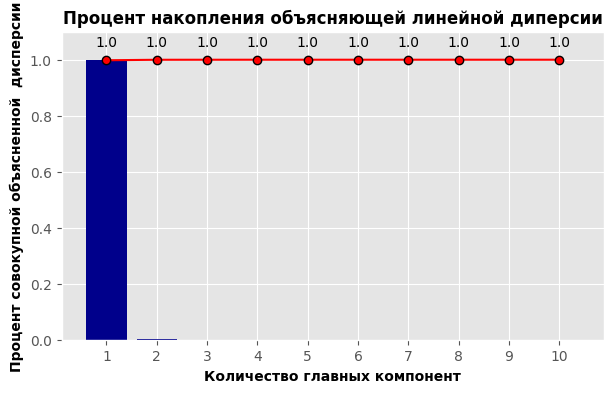

In [ ]:
prop_varianza_acum = pca.explained_variance_ratio_.cumsum()

fig, ax = plt.subplots(figsize=(7, 4))

ax.plot(
    np.arange(len(pd.DataFrame(data_pca).columns)) + 1,
    prop_varianza_acum,
    marker = 'o',
    color = 'red',
    markeredgecolor = 'black',
)

ax.bar(
    x      = np.arange(pca.n_components_) + 1,
    height = pca.explained_variance_ratio_,
    color = 'darkblue'
)

for x, y in zip(np.arange(len(pd.DataFrame(data_pca).columns)) + 1, prop_varianza_acum):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.set_ylim(0, 1.1)
ax.set_xticks(np.arange(pca.n_components_) + 1)
ax.set_title('Процент накопления объясняющей линейной диперсии', fontsize = 12, fontweight = 'bold', color = 'black')
ax.set_xlabel('Количество главных компонент',  fontsize = 10, fontweight = 'bold', color = 'black')
ax.set_ylabel('Процент совокупной объясненной  дисперсии',  fontsize = 10, fontweight = 'bold', color = 'black')
fig.show()

Я воспользовался кодом семинарского занятия, зачем изобретать велосипед. Мы видим что уже при 3 компонентах у нас дисперсия в данных объясняется практически полностью это хорошо, поскольку дылее мы как раз и будем использовать 2 и 3 компоненты

# Задание 4.

Сравнение результатов работы разных алгоритмов понижения размерности (3 балла)
Воспользуйтесь четырьмя любыми алгоритмами понижения размерности (n_components возьмите равным 2 или 3).

Создайте поле с двумерными или трехмерными графиками, на которых будут отображены результаты работы каждого алгоритма, а цветом будет обозначен тип вина (наша зависимая переменная).

Визуально оцените графики и сделайте вывод о том, какой метод отработал лучше.

Опишите результаты и качественно обоснуйте ваш выбор лучшего алгоритма. Если невозможно выбрать лучший алгоритм, также обоснуйте почему.

Критерии оценивания:
Выбранные графики адекватно отражают результаты работы алгоритма — 1 балл.
Описание результатов работы алгоритмов опирается на данные графиков — 1 балл.
Вывод о лучшем алгоритме обоснован — 1 балл.

## Начнем с PCA

In [ ]:
# Начнем с 3 компонентов
pca_3 = PCA(n_components = 3, random_state = 42)

data_pca_3 = pca_3.fit_transform(X)

In [ ]:
total_var = pca_3.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    data_pca_3, x=0, y=1, z=2, color=df['Type'],
    title=f'Общая объясненная дисперсия: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.show()

Процент объяснения дисперсии очень хорош, но мы видим что кластеры имеют перечения с которыми не все алгоритмы смогут справится, отложим вывод пока не посмотрим на все варианты

Теперь отработаем с помощью схлопывания до двух главных компонент

In [ ]:
pca_2 = PCA(n_components = 2, random_state = 42)

data_pca_2 = pca_2.fit_transform(X)

In [ ]:
total_var = pca_2.explained_variance_ratio_.sum() * 100

fig = px.scatter(
    data_pca_2, x=0, y=1, color=df['Type'],
    size=df['Type'],
    title=f'Общая объясненная дисперсия: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2'}

)


fig.show()

Если мы берем всего две компоненты процент объяснения дисперсии чуть ниже, но работать алгоритмам будет еще сложнее мы видим как пересекаются типы вина 2 и 3

## TSNE

In [ ]:
tsne_3 = TSNE(n_components = 3, random_state = 42)

data_tsne_3 = tsne_3.fit_transform(X)

In [ ]:
#total_var = tsne_3.  explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    data_tsne_3, x=0, y=1, z=2, color=df['Type'],
    title=f'Дисперсия наяву в исполнении TSNE',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.show()

Результат примерно такой же вина типа 1 стоят особняком, а вот вина типа 2 и 3 пересекаются - разделить линейно будет сложно (ну конечно леса и гиперплоскости с этим справятся)

In [ ]:
tsne_2 = TSNE(n_components = 2, random_state = 42)

data_tsne_2 = tsne_2.fit_transform(X)

In [ ]:
fig = px.scatter(
    data_tsne_2, x=0, y=1, color=df['Type'],
    size=df['Type'],
    title=f'Дисперсия в исполнении TSNE в двумерном пространстве',
    labels={'0': 'PC 1', '1': 'PC 2'}

)
fig.show()

График получился интересный, но мы попрежнему вижим много пересечений между типами вина

## UMAP

In [ ]:
umap_3 = umap.UMAP(n_components = 3, random_state = 42)

data_umap_3 = umap_3.fit_transform(X)

In [ ]:
fig = px.scatter_3d(
    data_umap_3, x=0, y=1, z=2, color=df['Type'],
    title=f'Дисперсия наяву в исполнении UMAP',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.show()

Вот тут появляются змеи, я заметил что это отличительная черта UMAP, но мы видим что попрежнему будут проблемы с классификацией. Я бы даже сказал что этот алгоритм хуже двух предыдущих

In [ ]:
umap_2 = umap.UMAP(n_components = 2, random_state = 42)

data_umap_2 = umap_2.fit_transform(X)

In [ ]:
fig = px.scatter(
    data_umap_2, x=0, y=1, color=df['Type'],
    size=df['Type'],
    title=f'Дисперсия в исполнении UMAP в двумерном пространстве',
    labels={'0': 'PC 1', '1': 'PC 2'}

)
fig.show()

Наши змеи только в двумерном пространстве, вывод такой же этот вариант хуже чем два предыдущих вида алгоритмов понижения размерности

## LocallyLinearEmbedding

In [ ]:
from sklearn.manifold import LocallyLinearEmbedding

In [ ]:
X_lle_3 = LocallyLinearEmbedding(n_components=3, random_state=42).fit_transform(X)

In [ ]:
fig = px.scatter_3d(
    X_lle_3, x=0, y=1, z=2, color=df['Type'],
    title=f'Дисперсия наяву в исполнении LocallyLinearEmbedding',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.show()

Очень интересно наши данные выстроились в линии, и опять мы видим что 3 и 2 очень похожи, плохой вариант. Они на одной линии - алгоритмам будет сложно

In [ ]:
X_lle_2 = LocallyLinearEmbedding(n_components=2, random_state=42).fit_transform(X)

In [ ]:
fig = px.scatter(
    X_lle_2, x=0, y=1, color=df['Type'],
    size=df['Type'],
    title=f'Дисперсия в исполнении LocallyLinearEmbedding в двумерном пространстве',
    labels={'0': 'PC 1', '1': 'PC 2'}

)
fig.show()

Оценка - неуд, тип 1 выстроился в линию, а 2 и3 смешались, плюс есть еще и точки выбросы, наверно для поиска аномалий это было бы полезно, но нам нужно классифицировать вина

## LDA

Последним вариантом попробуем LDA

In [ ]:
lda_2 = LDA(n_components=2)
# Taking in as second argument the Target as labels
X_LDA_2D = lda_2.fit_transform(X, df['Type'])

In [ ]:
fig = px.scatter(
    X_LDA_2D, x=0, y=1, color=df['Type'],
    size=df['Type'],
    title=f'Дисперсия в исполнении LDA в двумерном пространстве',
    labels={'0': 'PC 1', '1': 'PC 2'}

)
fig.show()

Чудеса, но он обошелся 2мерным пространством и разделил их реально разделил - ни одного перечечения!!!! - думаю что это победа

# Задание 5.

Сравнение результатов работы алгоритмов (4 балла)
Разделите выборку на обучающую и тестовую.

Используйте два метода понижения размерности, которые лучше всего показали себя в предыдущем задании, а также исходные данные без понижения размерности.

Примените 6 любых алгоритмов классификации на этих трех типах данных.

Постройте два sns.heatmap() (для train и test). В каждом из них должно быть по 18 ячеек (6 алгоритмов х 3 вида данных) — в каждой ячейке должно быть указано значение Accuracy для определенного алгоритма с определенными данными. Аналогичную работу мы проделывали на семинаре.

Определите, какой алгоритм дал лучшие результаты и дайте письменное обоснование своего решения:

Как алгоритмы отрабатывают при работе на данных без понижения размерности?
В чем разница в полученных значениях?
Критерии оценивания:
Эксперимент поставлен корректно — 1 балл.
Тепловая карта построена корректно — 1 балл.
Построенные графики визуализируют необходимые зависимости — 1 балл.
Письменное обоснование выбора проведено корректно: не содержит логических ошибок, предположения обоснованны и опираются на данные графиков — 1 балл.

Сначала попробуем ту логику в рамках которой мы работали на семинаре

In [ ]:
X = df.drop('Type', axis = 1)
y = df['Type']

SEED = 42

X_train, X_test, y_train, y_test = tts(X,
                                       y,
                                       test_size = 0.2,
                                       random_state = SEED,
                                       stratify = y)

In [ ]:
pca = PCA(n_components = 3, random_state = SEED)

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.fit_transform(X_test)

In [ ]:
tsne = TSNE(n_components = 3, random_state = SEED)

X_train_tsne = tsne.fit_transform(X_train)
X_test_tsne = tsne.transform(X_test)

In [ ]:
X_train_final = [X_train_pca, X_train_tsne, X_train]
X_test_final = [X_test_pca, X_test_tsne, X_test]
reductions = ['PCA', 'TSNE', 'ALL_FEATURES']

In [ ]:
from sklearn.svm import SVC

In [ ]:
clf1 = LogisticRegression(random_state = SEED)
clf2 = RandomForestClassifier(random_state = SEED)
clf3 = ExtraTreesClassifier(random_state = SEED)
clf4 = SVC(random_state = SEED, gamma='auto')
clf5 = LGBMClassifier(random_state = SEED, verbosity = -1)
clf6 = CatBoostClassifier(random_state = SEED, verbose = 0)

MODELS = [clf1, clf2, clf3, clf4, clf5, clf6]

In [ ]:
names = []

reduction_train = {'PCA':[], 'TSNE':[], 'ALL_FEATURES':[]}
reduction_test = {'PCA':[], 'TSNE':[], 'ALL_FEATURES':[]}

for model in tqdm(MODELS):
    name = type(model).__name__
    names.append(name)

    for i,(x_train, x_test, reduction) in enumerate(zip(X_train_final, X_test_final, reductions)):
        model.fit(x_train, y_train)
        y_pred_train = model.predict(x_train)
        y_pred_test = model.predict(x_test)

        accuracy_train = accuracy_score(y_train, y_pred_train)
        reduction_train[reduction].append(accuracy_train)

        accuracy_test = accuracy_score(y_test, y_pred_test)
        reduction_test[reduction].append(accuracy_test)

    print(f'* {name} finished.')

  0%|          | 0/6 [00:00<?, ?it/s]

* LogisticRegression finished.
* RandomForestClassifier finished.
* ExtraTreesClassifier finished.
* SVC finished.
* LGBMClassifier finished.
* CatBoostClassifier finished.


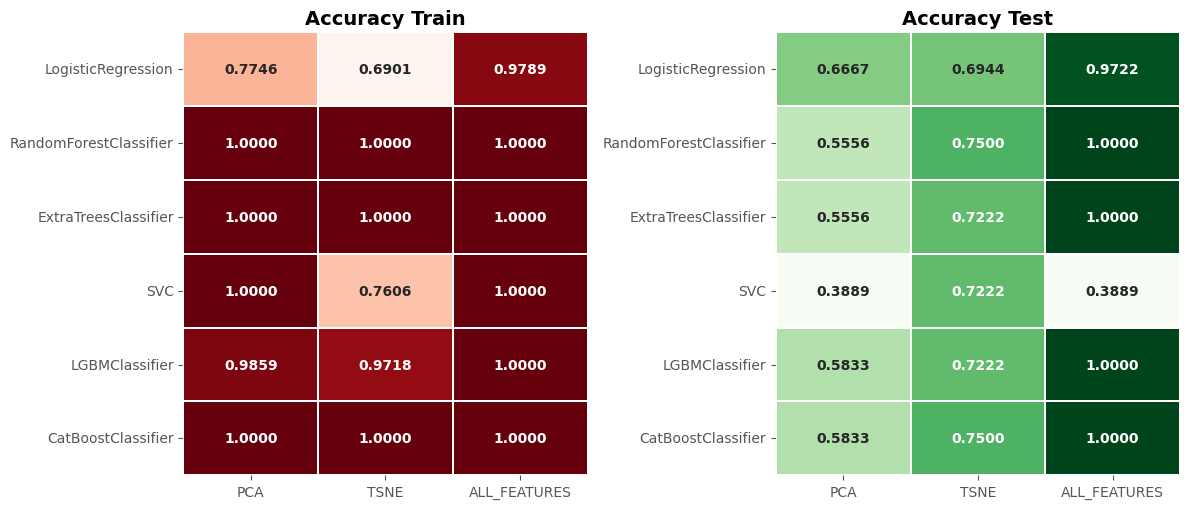

In [ ]:
fig,axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5.2))
axs = axs.flat

sns.heatmap(pd.DataFrame(index = names, data = reduction_train),
            cmap = 'Reds',
            annot = True,
            annot_kws = {'fontweight':'bold'},
            fmt = '.4f',
            linewidths = 1.1,
            square = False,
            cbar = False,
            ax = axs[0])
sns.heatmap(pd.DataFrame(index = names, data = reduction_test),
            cmap = 'Greens',
            annot = True,
            annot_kws = {'fontweight':'bold'},
            fmt = '.4f',
            linewidths = 1.1,
            square = False,
            cbar = False,
            ax = axs[1])
axs[0].set_title("Accuracy Train", fontsize = 14, fontweight = 'bold', color = 'black')
axs[1].set_title("Accuracy Test", fontsize = 14, fontweight = 'bold', color = 'black')

fig.tight_layout()
fig.show()

Мы видим что и на тренировочном и на тестовом наборе как то так получается, что использование всех характеристик лучше, ошибаются у нас логистическая регрессия и метод опорных векторов (но он очень тонкий в настройках, я туда не полез). Тестовый прогон а именно он имеет значение показал, что лучший вариант понижения размерности это TSNE. Как мы и предполагали эти алгоритмы хорошо слогли обхяснить дисперсию, но для подачи в ML оказались пригодны слабо. И это мы видели на графиках, когда отмечали невозможность разделить красные и желтые точки. Но куда мы дели LDA? нет мы его не зыбыли, для его корректной работы нужно преобразовать весб датасет, а потом уже бить данные на тренировочную и тестовую выборки - что же добавим его в наше соревноваение

Для LDA cначала снизим размерность потом разобьем

In [ ]:
lda_2 = LDA(n_components=2)
# Taking in as second argument the Target as labels
X_LDA_2D = lda_2.fit_transform(X, df['Type'])

In [ ]:
X_train_lda, X_test_lda, y_train, y_test = tts(X_LDA_2D,
                                       df['Type'],
                                       test_size = 0.2,
                                       random_state = SEED,
                                       stratify = df['Type'])

Нечестно не предоставить другим алгоритмам аналогичный шанс, мы за чистоту эксперимента

In [ ]:
pca = PCA(n_components = 3, random_state = SEED)

X_pca = pca.fit_transform(X)

X_train_pca, X_test_pca, y_train, y_test = tts(X_pca,
                                       df['Type'],
                                       test_size = 0.2,
                                       random_state = SEED,
                                       stratify = df['Type'])


In [ ]:
tsne = TSNE(n_components = 3, random_state = SEED)

X_tsne = tsne.fit_transform(X)

X_train_tsne, X_test_tsne, y_train, y_test = tts(X_tsne,
                                       df['Type'],
                                       test_size = 0.2,
                                       random_state = SEED,
                                       stratify = df['Type'])


In [ ]:
X_train_final = [X_train_pca, X_train_tsne, X_train_lda,  X_train]
X_test_final = [X_test_pca, X_test_tsne, X_test_lda, X_test]
reductions = ['PCA', 'TSNE', 'LDA', 'ALL_FEATURES']

In [ ]:
names = []

reduction_train = {'PCA':[], 'TSNE':[], 'LDA':[], 'ALL_FEATURES':[]}
reduction_test = {'PCA':[], 'TSNE':[], 'LDA':[], 'ALL_FEATURES':[]}

for model in tqdm(MODELS):
    name = type(model).__name__
    names.append(name)

    for i,(x_train, x_test, reduction) in enumerate(zip(X_train_final, X_test_final, reductions)):
        model.fit(x_train, y_train)
        y_pred_train = model.predict(x_train)
        y_pred_test = model.predict(x_test)

        accuracy_train = accuracy_score(y_train, y_pred_train)
        reduction_train[reduction].append(accuracy_train)

        accuracy_test = accuracy_score(y_test, y_pred_test)
        reduction_test[reduction].append(accuracy_test)

    print(f'* {name} finished.')

  0%|          | 0/6 [00:00<?, ?it/s]

* LogisticRegression finished.
* RandomForestClassifier finished.
* ExtraTreesClassifier finished.
* SVC finished.
* LGBMClassifier finished.
* CatBoostClassifier finished.


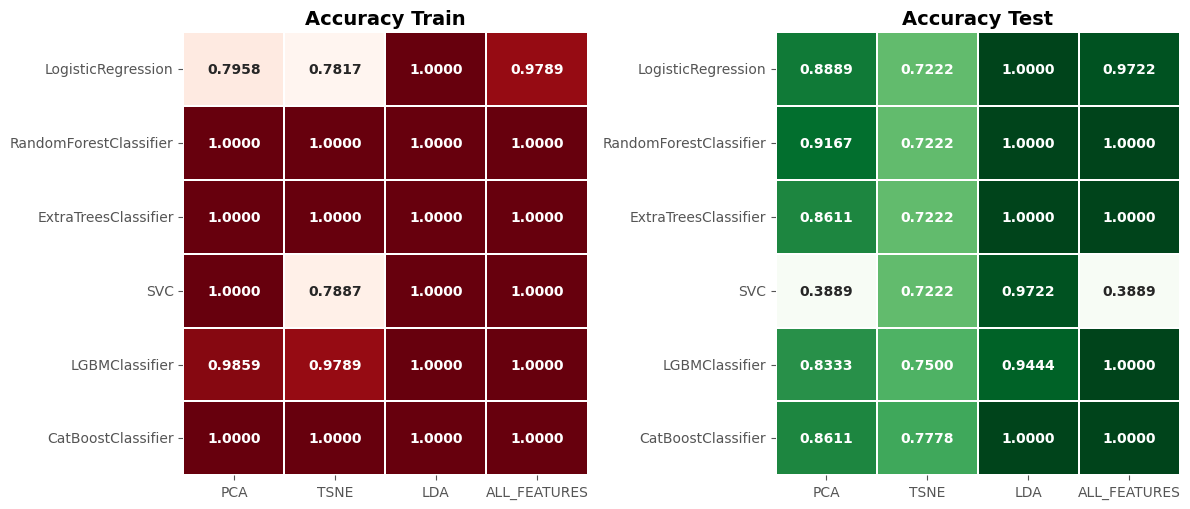

In [ ]:
fig,axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5.2))
axs = axs.flat

sns.heatmap(pd.DataFrame(index = names, data = reduction_train),
            cmap = 'Reds',
            annot = True,
            annot_kws = {'fontweight':'bold'},
            fmt = '.4f',
            linewidths = 1.1,
            square = False,
            cbar = False,
            ax = axs[0])
sns.heatmap(pd.DataFrame(index = names, data = reduction_test),
            cmap = 'Greens',
            annot = True,
            annot_kws = {'fontweight':'bold'},
            fmt = '.4f',
            linewidths = 1.1,
            square = False,
            cbar = False,
            ax = axs[1])
axs[0].set_title("Accuracy Train", fontsize = 14, fontweight = 'bold', color = 'black')
axs[1].set_title("Accuracy Test", fontsize = 14, fontweight = 'bold', color = 'black')

fig.tight_layout()
fig.show()

Так и что же мы получили? А вот что алгоритм PSA который ранее снижал размерность теста и трейна отдельно а сейчас сначала снизил размерность на трейн и тест отработал гораздо лучше мы видим 0.8 +, напротив у алгоритма TSNE каких либо значимых улучшений нет, ну разве что где то 0.75 доросло до 0.77 а где то наборот упало с 0.75 до 0.72. А вот наш алгорим LDA - показал себя точным лидером. Он великолепно справился с трейном, помог несчастному SVC дойти до 0.90+ и отработал на 1 по всем другим алгоримам кроме LGBM, даже на простой логистической регрессии 1!!! Причину мы видели на графике - абсолютно четкие 3 кластера!

Не берусь судить насколько это читерно, ведь мы помним LDA использует таргет при трансформации, то есть он заточен под конкретный y. Но условий этот алгоритм не нарушал - объявим его победителем

# Задание 6.

Более пристальный анализ (2 балла)
Для лучшего алгоритма из предыдущего задания постройте Classification Report, Confusion Matrix, Precision Recall Curve, ROC Curve.

Удалось ли обнаружить какие-то аномалии в работе нашего алгоритма?

Можем ли мы принять полученные результаты?

Критерии оценивания:
По одному баллу за обоснованный ответ на каждый вопрос.

Если смотреть по строкам то лучший алгоритм - это случайный лес, рядом был catbust но он невероятно громоздкий по сравнению с изяшными лесами. Ну и конечно мы берем победителя в части снижения размерности и оказался LDA

In [ ]:
model = RandomForestClassifier(random_state = SEED)
model.fit(X_train_lda, y_train)

y_pred_train = model.predict(X_train_lda)
y_pred_test = model.predict(X_test_lda)

y_pred_prob_train = model.predict_proba(X_train_lda)[:,1]
y_pred_prob_test = model.predict_proba(X_test_lda)[:,1]

In [ ]:
print("##" * 40)
print(" " * 25, "Classification Report Train")
print("##" * 40)
print(classification_report(y_train, y_pred_train))
print("")

print("##" * 40)
print(" " * 25, "Classification Report Test")
print("##" * 40)
print(classification_report(y_test, y_pred_test))

################################################################################
                          Classification Report Train
################################################################################
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        47
           2       1.00      1.00      1.00        57
           3       1.00      1.00      1.00        38

    accuracy                           1.00       142
   macro avg       1.00      1.00      1.00       142
weighted avg       1.00      1.00      1.00       142


################################################################################
                          Classification Report Test
################################################################################
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        12
           2       1.00      1.00      1.00        14
           3       1.00 

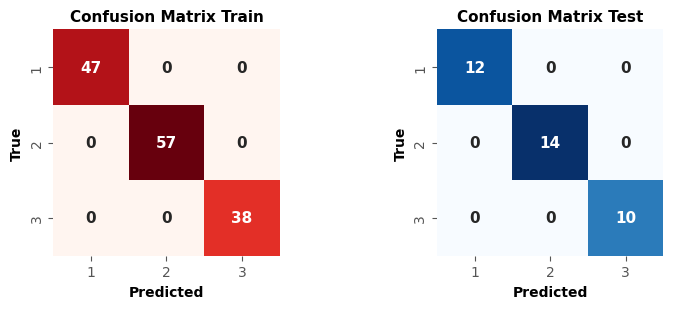

In [ ]:
from sklearn.metrics import confusion_matrix

# Определите метки классов в виде строк
class_labels = ['1', '2', '3']

# Вычислите матрицу ошибок с явно указанными метками классов
cf_mx_train = confusion_matrix(y_train, y_pred_train)
cf_mx_test = confusion_matrix(y_test, y_pred_test)

# Создайте графики
fig,axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 3.2))
axs = axs.flat

# Отобразите матрицы ошибок
sns.heatmap(cf_mx_train, cmap='Reds', annot=True, annot_kws={'fontsize':11, 'fontweight':'bold'}, fmt='', cbar=False, square=True, ax=axs[0])
sns.heatmap(cf_mx_test, cmap='Blues', annot=True, annot_kws={'fontsize':11, 'fontweight':'bold'}, fmt='', cbar=False, square=True, ax=axs[1])

# Добавьте подписи и заголовки
axs[0].set_xlabel('Predicted', fontsize=10, fontweight="bold", color="black")
axs[1].set_xlabel('Predicted', fontsize=10, fontweight="bold", color="black")
axs[0].set_ylabel('True', fontsize=10, fontweight="bold", color="black")
axs[1].set_ylabel('True', fontsize=10, fontweight="bold", color="black")
axs[0].set_title('Confusion Matrix Train', fontsize=11, fontweight="bold", color="black")
axs[1].set_title('Confusion Matrix Test', fontsize=11, fontweight="bold", color="black")

# Установите метки на осях
axs[0].set_xticklabels(class_labels)
axs[0].set_yticklabels(class_labels)
axs[1].set_xticklabels(class_labels)
axs[1].set_yticklabels(class_labels)

# Показать графики
fig.tight_layout()
plt.show()


In [ ]:
y_train.value_counts()

2    57
1    47
3    38
Name: Type, dtype: int64

In [ ]:
y_test.value_counts()

2    14
1    12
3    10
Name: Type, dtype: int64

Мы видим что все классы предсказаны верно и проблем как таковых нет, сделать какой либо вывод кроме того что LDA сработал хорошо я не могу

In [ ]:
precision_train, recall_train, _ = precision_recall_curve(y_train, y_pred_prob_train)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_pred_prob_test)

plt.figure(figsize = (5,3.6))
plt.plot(recall_train, precision_train, label = 'Train')
plt.plot(recall_test, precision_test, label = 'Test')
plt.xlabel("Recall", fontsize = 10, fontweight = 'bold', color = 'black')
plt.ylabel("Precision", fontsize = 10, fontweight = 'bold', color = 'black')
plt.title("Precison Recall Curve", fontsize = 12, fontweight = 'bold', color = 'black')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

ValueError: multiclass format is not supported

Так так тут стандартный подход не пойдет код заточен под бинарную классификацию, выкрутимся, дабы есть уже готовое решение

In [ ]:
%pip install yellowbrick

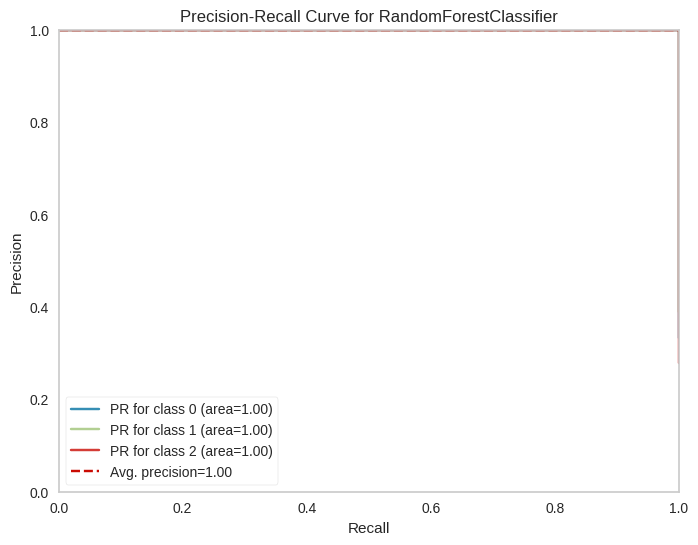

<Axes: title={'center': 'Precision-Recall Curve for RandomForestClassifier'}, xlabel='Recall', ylabel='Precision'>

In [159]:
from yellowbrick.classifier import PrecisionRecallCurve

# Построение кривой Precision-Recall для многоклассовой классификации
plt.figure(figsize=(8, 6))
viz = PrecisionRecallCurve(model, per_class=True, line_width=2)  # Задаем толщину линий равную 2
viz.fit(X_train_lda, y_train)
viz.score(X_test_lda, y_test)
viz.show()


Везде 1 как и ожидалось

In [ ]:
fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_prob_train)
auc_train = roc_auc_score(y_train, y_pred_prob_train)

fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_prob_test)
auc_test = roc_auc_score(y_test, y_pred_prob_test)

plt.figure(figsize = (5,3.6))
plt.plot(fpr_train, tpr_train, label = f'Train: {auc_train:.4f}')
plt.plot(fpr_test, tpr_test, label = f'Test: {auc_test:.4f}')
plt.xlabel("False Positive Rate", fontsize = 10, fontweight = 'bold', color = 'black')
plt.ylabel("True Positive Rate", fontsize = 10, fontweight = 'bold', color = 'black')
plt.title("ROC Curve", fontsize = 12, fontweight = 'bold', color = 'black')
plt.legend()
plt.plot([0,1], linestyle = '--', color = 'black')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

ValueError: multiclass format is not supported

Тут тоже самое, выкручиваемся с помощью йеллоубрик

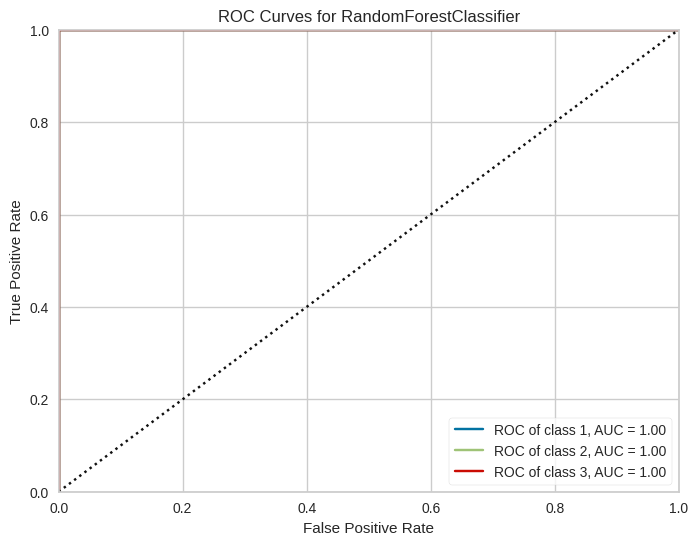

<Axes: title={'center': 'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [160]:

from yellowbrick.classifier import ROCAUC

# Построение ROC-кривой для многоклассовой классификации
plt.figure(figsize=(8, 6))
viz = ROCAUC(model, per_class=True, macro=False, micro=False, line_width=2)  # Задаем параметры визуализации
viz.fit(X_train_lda, y_train)
viz.score(X_test_lda, y_test)
viz.show()


Идеально! - LDA - лучший

А давайте проверим на "не очень" идеальной модели возьмем тот же PSA как мы помним он чуть чуть ошибся у нас на тесте возьмем тот же случайный лес

In [162]:
model = RandomForestClassifier(random_state = SEED)
model.fit(X_train_pca, y_train) # вот тут поменяем чуть чуть

y_pred_train = model.predict(X_train_pca)
y_pred_test = model.predict(X_test_pca)

y_pred_prob_train = model.predict_proba(X_train_pca)[:,1]
y_pred_prob_test = model.predict_proba(X_test_pca)[:,1]

In [163]:
print("##" * 40)
print(" " * 25, "Classification Report Train")
print("##" * 40)
print(classification_report(y_train, y_pred_train))
print("")

print("##" * 40)
print(" " * 25, "Classification Report Test")
print("##" * 40)
print(classification_report(y_test, y_pred_test))

################################################################################
                          Classification Report Train
################################################################################
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        47
           2       1.00      1.00      1.00        57
           3       1.00      1.00      1.00        38

    accuracy                           1.00       142
   macro avg       1.00      1.00      1.00       142
weighted avg       1.00      1.00      1.00       142


################################################################################
                          Classification Report Test
################################################################################
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        12
           2       0.87      0.93      0.90        14
           3       0.89 

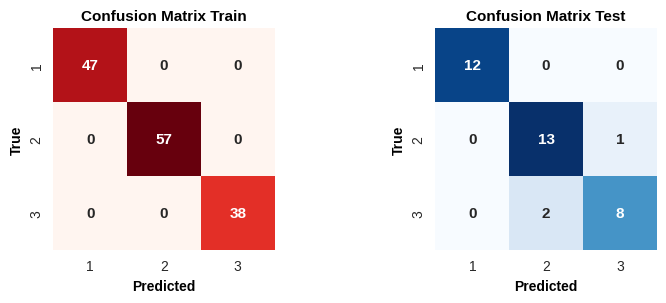

In [164]:
# Определите метки классов в виде строк
class_labels = ['1', '2', '3']

# Вычислите матрицу ошибок с явно указанными метками классов
cf_mx_train = confusion_matrix(y_train, y_pred_train)
cf_mx_test = confusion_matrix(y_test, y_pred_test)

# Создайте графики
fig,axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 3.2))
axs = axs.flat

# Отобразите матрицы ошибок
sns.heatmap(cf_mx_train, cmap='Reds', annot=True, annot_kws={'fontsize':11, 'fontweight':'bold'}, fmt='', cbar=False, square=True, ax=axs[0])
sns.heatmap(cf_mx_test, cmap='Blues', annot=True, annot_kws={'fontsize':11, 'fontweight':'bold'}, fmt='', cbar=False, square=True, ax=axs[1])

# Добавьте подписи и заголовки
axs[0].set_xlabel('Predicted', fontsize=10, fontweight="bold", color="black")
axs[1].set_xlabel('Predicted', fontsize=10, fontweight="bold", color="black")
axs[0].set_ylabel('True', fontsize=10, fontweight="bold", color="black")
axs[1].set_ylabel('True', fontsize=10, fontweight="bold", color="black")
axs[0].set_title('Confusion Matrix Train', fontsize=11, fontweight="bold", color="black")
axs[1].set_title('Confusion Matrix Test', fontsize=11, fontweight="bold", color="black")

# Установите метки на осях
axs[0].set_xticklabels(class_labels)
axs[0].set_yticklabels(class_labels)
axs[1].set_xticklabels(class_labels)
axs[1].set_yticklabels(class_labels)

# Показать графики
fig.tight_layout()
plt.show()

Да мы видим что у этого алгоритма возникли проблемы в классификацией 2 и 3 мы это видели еще на стадии визуализации, так что ошибка на тесте ожидаема

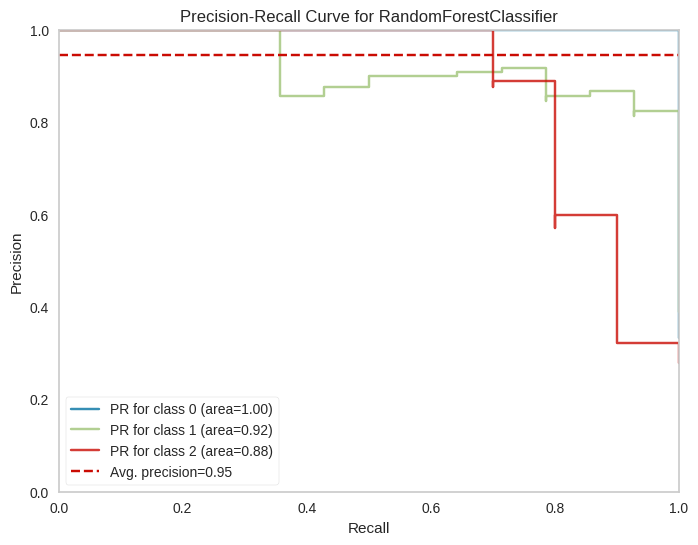

<Axes: title={'center': 'Precision-Recall Curve for RandomForestClassifier'}, xlabel='Recall', ylabel='Precision'>

In [168]:
# Построение кривой Precision-Recall для многоклассовой классификации
plt.figure(figsize=(8, 6))
viz = PrecisionRecallCurve(model, per_class=True, line_width=2)  # Задаем толщину линий равную 2
viz.fit(X_train_pca, y_train)
viz.score(X_test_pca, y_test)
viz.show()

Вот тут мы забыли немного поменять лейблы певый класс это 0 его мы определяем хорошо а вот 2 и 3 (1 и 2 соответсвенно тут мы хуже особенно большие проблемы с классом 3)

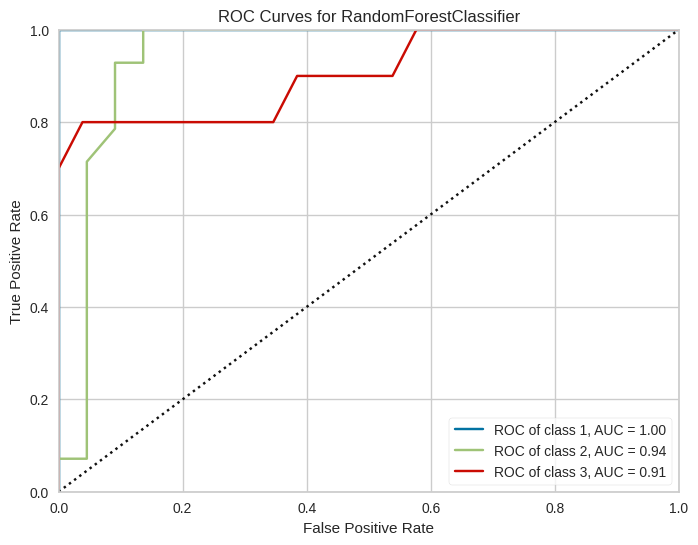

<Axes: title={'center': 'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [166]:
# Построение ROC-кривой для многоклассовой классификации
plt.figure(figsize=(8, 6))
viz = ROCAUC(model, per_class=True, macro=False, micro=False, line_width=2)  # Задаем параметры визуализации
viz.fit(X_train_pca, y_train)
viz.score(X_test_pca, y_test)
viz.show()

Результат мы получили предсказуемый, лесные модели славятся своими прямыми линиями на такой визуализации